In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Libraries**

In [ ]:
!pip install easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 kB 21.1 MB/s eta 0:00:00


In [ ]:
import easyocr

import pandas as pd
import os
import cv2
import numpy as np
import json
import random
import re
# import tqdm.auto
import time
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW


# import tensorflow as tf
# from tensorflow.keras import layers, models
# from tensorflow.keras.preprocessing.text import Tokenizer
# # from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.optimizers import Adam
# # from tensorflow.keras.callbacks import EarlyStopping
# import transformers
# from transformers import BertTokenizer, TFBertForSequenceClassification, TFBertModel


# **Preparing Datasets**

## Directoring document images dataset directory

In [ ]:
# Directory containing the document images
ktp_image_dir = "/content/drive/MyDrive/Skripsi/Datasets/KTP Datasets"
sim_image_dir = "/content/drive/MyDrive/Skripsi/Datasets/SIM Datasets"

ktp_image_files = os.listdir(ktp_image_dir)
sim_image_files = os.listdir(sim_image_dir)

### Preprocess Document Image

In [ ]:
def preprocess_image(image_path):
  # Load image with OpenCV
  image = cv2.imread(image_path)

  # Convert to grayscale
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # Increase contrast
  contrast = cv2.convertScaleAbs(gray, alpha=2.0, beta=0)

  # Apply thresholding
  _, binary = cv2.threshold(contrast, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

  # Resize image
  resized = cv2.resize(binary, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)

  # Remove noise
  denoised = cv2.medianBlur(resized, 3)

  return denoised

## **Kartu Tanda Penduduk (KTP)**

### Extracted Text from Document Image into a Dataframe

In [ ]:
data = []
reader = easyocr.Reader(['id'])

for image_file in ktp_image_files:
  image_path = os.path.join(ktp_image_dir, image_file)

  # Preprocess the image
  processed_image = preprocess_image(image_path)

  text = reader.readtext(processed_image)

  extracted_text = "\n".join([result[1] for result in text])

  if 'ktp' in image_file.lower():
    label = 'KTP'
  elif 'sim' in image_file.lower():
    label = 'SIM'
  else:
    label = 'Unknown'

  data.append({"text": extracted_text, "label": label})

### Converting to Dataframe and save to CSV

In [ ]:
# Create a DataFrame and save to CSV
df_ktp = pd.DataFrame(data)
# df_ktp.to_csv("/content/drive/MyDrive/Skripsi/Datasets/ktp_uncleaned_datasets.csv", index=False)

df_ktp

,text,label
0,PROVINSI ACEH\nKOTA BANDA ACEH\nNIK\n279237700...,KTP
1,PROVINSI SULAWESI SELATAN\nKOTA MAKASSAR\nNIK\...,KTP
2,PROVINSI DAERAH ISTIMEWA YOGYAKARTA\nKOTA YOGY...,KTP
3,PROVINSI PAPUA\nKOTA JAYAPURA\nNIK\n2792377005...,KTP
4,PROVINSI BALI\nKOTA DENPASAR\nNIK\n27923770058...,KTP
...,...,...
495,PROVINSI SUMATERA UTARA\nKOTA MEDAN\nNIK\n2792...,KTP
496,PROVINSI BANTEN\nKOTA TANGERANG\nNIK\n27923770...,KTP
497,PROVINSI SUMATERA UTARA\nKOTA MEDAN\nNIK\n2792...,KTP
498,PROVINSI PAPUA\nKOTA JAYAPURA\nNIK\n2792377005...,KTP


### Randomize NIK Number

In [ ]:
def randomize_nik(text):
    pattern = r'\b\d{16}\b'

    # Apply the randomization
    return re.sub(pattern, ''.join(random.choices('0123456789', k=16)), text)

In [ ]:
df_ktp_nik_random = pd.DataFrame()
df_ktp_nik_random['original_text'] = df_ktp['text']
df_ktp_nik_random['randomize_nik'] = df_ktp['text'].apply(randomize_nik)

# Randomize NIK number (saving to df_ktp dataframe)
df_ktp['text'] = df_ktp['text'].apply(randomize_nik)

# Displaying text comparison
df_ktp_nik_random[['original_text', 'randomize_nik']]

,original_text,randomize_nik
0,PROVINSI ACEH\nKOTA BANDA ACEH\nNIK\n279237700...,PROVINSI ACEH\nKOTA BANDA ACEH\nNIK\n537413053...
1,PROVINSI SULAWESI SELATAN\nKOTA MAKASSAR\nNIK\...,PROVINSI SULAWESI SELATAN\nKOTA MAKASSAR\nNIK\...
2,PROVINSI DAERAH ISTIMEWA YOGYAKARTA\nKOTA YOGY...,PROVINSI DAERAH ISTIMEWA YOGYAKARTA\nKOTA YOGY...
3,PROVINSI PAPUA\nKOTA JAYAPURA\nNIK\n2792377005...,PROVINSI PAPUA\nKOTA JAYAPURA\nNIK\n3493153776...
4,PROVINSI BALI\nKOTA DENPASAR\nNIK\n27923770058...,PROVINSI BALI\nKOTA DENPASAR\nNIK\n95149417588...
...,...,...
495,PROVINSI SUMATERA UTARA\nKOTA MEDAN\nNIK\n2792...,PROVINSI SUMATERA UTARA\nKOTA MEDAN\nNIK\n2530...
496,PROVINSI BANTEN\nKOTA TANGERANG\nNIK\n27923770...,PROVINSI BANTEN\nKOTA TANGERANG\nNIK\n01356054...
497,PROVINSI SUMATERA UTARA\nKOTA MEDAN\nNIK\n2792...,PROVINSI SUMATERA UTARA\nKOTA MEDAN\nNIK\n0489...
498,PROVINSI PAPUA\nKOTA JAYAPURA\nNIK\n2792377005...,PROVINSI PAPUA\nKOTA JAYAPURA\nNIK\n2457489402...


### Fix typo dict (filtering)

In [ ]:
corrections = json.load(open('/content/drive/MyDrive/Skripsi/JSON Dict/ktp_correct_text.json'))

def correct_text(text):
  words = text.split()
  corrected_words = []
  for word in words:
    if word in corrections:
      corrected_words.append(corrections[word])
    else:
      corrected_words.append(word)

  corrected_text = ' '.join(corrected_words)
  # Remove double spaces
  corrected_text = re.sub(' +', ' ', corrected_text)
  return corrected_text

In [ ]:
df_ktp_corrected = pd.DataFrame()
if 'text' in df_ktp.columns:
    # Create a copy of the original text
    df_ktp_corrected['original_text'] = df_ktp['text']

    # Apply the correction to the 'text' column
    df_ktp_corrected['corrected_text'] = df_ktp['text'].apply(correct_text)

    # Applying to dataframe
    df_ktp['text'] = df_ktp['text'].apply(correct_text)
else:
    print("The column 'text' does not exist in the DataFrame.")

df_ktp_corrected[['original_text', 'corrected_text']]

,original_text,corrected_text
0,PROVINSI ACEH\nKOTA BANDA ACEH\nNIK\n649329016...,PROVINSI ACEH KOTA BANDA ACEH NIK: 64932901636...
1,PROVINSI SULAWESI SELATAN\nKOTA MAKASSAR\nNIK\...,PROVINSI SULAWESI SELATAN KOTA MAKASSAR NIK: 3...
2,PROVINSI DAERAH ISTIMEWA YOGYAKARTA\nKOTA YOGY...,PROVINSI DAERAH ISTIMEWA YOGYAKARTA KOTA YOGYA...
3,PROVINSI PAPUA\nKOTA JAYAPURA\nNIK\n4174591702...,PROVINSI PAPUA KOTA JAYAPURA NIK: 417459170286...
4,PROVINSI BALI\nKOTA DENPASAR\nNIK\n88969441416...,PROVINSI BALI KOTA DENPASAR NIK: 8896944141609...
...,...,...
495,PROVINSI SUMATERA UTARA\nKOTA MEDAN\nNIK\n4284...,PROVINSI SUMATERA UTARA KOTA MEDAN NIK: 428484...
496,PROVINSI BANTEN\nKOTA TANGERANG\nNIK\n71863990...,PROVINSI BANTEN KOTA TANGERANG NIK: 7186399022...
497,PROVINSI SUMATERA UTARA\nKOTA MEDAN\nNIK\n9076...,PROVINSI SUMATERA UTARA KOTA MEDAN NIK: 907621...
498,PROVINSI PAPUA\nKOTA JAYAPURA\nNIK\n5430334021...,PROVINSI PAPUA KOTA JAYAPURA NIK: 543033402150...


In [ ]:
df_ktp.to_csv('/content/drive/MyDrive/Skripsi/Cleaned Datasets/ktp_cleaned_dataset.csv', index=False)

In [ ]:
df_ktp

,text,label
0,PROVINSI ACEH KOTA BANDA ACEH NIK: 64932901636...,KTP
1,PROVINSI SULAWESI SELATAN KOTA MAKASSAR NIK: 3...,KTP
2,PROVINSI DAERAH ISTIMEWA YOGYAKARTA KOTA YOGYA...,KTP
3,PROVINSI PAPUA KOTA JAYAPURA NIK: 417459170286...,KTP
4,PROVINSI BALI KOTA DENPASAR NIK: 8896944141609...,KTP
...,...,...
495,PROVINSI SUMATERA UTARA KOTA MEDAN NIK: 428484...,KTP
496,PROVINSI BANTEN KOTA TANGERANG NIK: 7186399022...,KTP
497,PROVINSI SUMATERA UTARA KOTA MEDAN NIK: 907621...,KTP
498,PROVINSI PAPUA KOTA JAYAPURA NIK: 543033402150...,KTP


## **Surat Izin Mengemudi (SIM)**

### Extracted Text from Document Image into a Dataframe

In [ ]:
data = []
reader = easyocr.Reader(['id'])

for image_file in sim_image_files:
  image_path = os.path.join(sim_image_dir, image_file)

  processed_image = preprocess_image(image_path)

  text = reader.readtext(processed_image)

  extracted_text = "\n".join([result[1] for result in text])

  if 'ktp' in image_file.lower():
    label = 'KTP'
  elif 'sim' in image_file.lower():
    label = 'SIM'
  else:
    label = 'Unknown'

  data.append({"text": extracted_text, "label": label})

/usr/local/lib/python3.10/dist-packages/easyocr/detection.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(copyStateDict(torch.load(trained_model, ma

### Converting to Dataframe and save to CSV

In [ ]:
# Create a DataFrame and save to CSV
df_sim = pd.DataFrame(data)
df_sim.to_csv("/content/drive/MyDrive/Skripsi/Datasets/sim_uncleaned_datasets.csv", index=False)

# df_sim = pd.read_csv("/content/drive/MyDrive/Skripsi/Datasets/sim_uncleaned_datasets.csv")
df_sim

,text,label
0,INDONESIA\nDRNING LICENSE\nSURAT IZIN MENıEMUD...,SIM
1,INDONESIA\nDRNING LICENSE\nSURAT IZIN MENıEMUD...,SIM
2,INDONESIA\nDRNING LICENSE\nSURAT IZIN MENıEMUD...,SIM
3,INDONESIA\nDRNING LICENSE\nSURAT IZIN MENıEMUD...,SIM
4,INDONESIA\nDRNING LICENSE\nSURAT IZIN MENıEMUD...,SIM
...,...,...
495,INDONESIA\nDRNING LICENSE\nSURAT IZIN MENıEMUD...,SIM
496,INDONESIA\nDRNING LICENSE\nSURAT IZIN MENıEMUD...,SIM
497,INDONESIA\nDRNING LICENSE\nSURAT IZIN MENıEMUD...,SIM
498,INDONESIA\nDRNING LICENSE\nSURAT IZIN MENıEMUD...,SIM


### Randomize Driving License Number

In [ ]:
# WILL BE MODIFIED LATER
def randomize_driving_license_number(text):
  pattern = r'\b\d{4}-\d{4}-\d{5}\b'

  # Apply the randomization
  return re.sub(pattern, '{}-{}-{}'.format(
      ''.join(random.choices('0123456789', k=4)),
      ''.join(random.choices('0123456789', k=4)),
      ''.join(random.choices('0123456789', k=5))),
                text)

In [ ]:
df_sim_dl_number_random = pd.DataFrame()
df_sim_dl_number_random['original_text'] = df_sim['text']
df_sim_dl_number_random['randomize_driving_license_number'] = df_sim['text'].apply(randomize_driving_license_number)

# Randomize Driving License number (saving to df_sim dataframe)
df_sim['text'] = df_sim['text'].apply(randomize_driving_license_number)

# Displaying text comparison
df_sim_dl_number_random[['original_text', 'randomize_driving_license_number']]

,original_text,randomize_driving_license_number
0,INDONESIA\nDRNING LICENSE\nSURAT IZIN MENıEMUD...,INDONESIA\nDRNING LICENSE\nSURAT IZIN MENıEMUD...
1,INDONESIA\nDRNING LICENSE\nSURAT IZIN MENıEMUD...,INDONESIA\nDRNING LICENSE\nSURAT IZIN MENıEMUD...
2,INDONESIA\nDRNING LICENSE\nSURAT IZIN MENıEMUD...,INDONESIA\nDRNING LICENSE\nSURAT IZIN MENıEMUD...
3,INDONESIA\nDRNING LICENSE\nSURAT IZIN MENıEMUD...,INDONESIA\nDRNING LICENSE\nSURAT IZIN MENıEMUD...
4,INDONESIA\nDRNING LICENSE\nSURAT IZIN MENıEMUD...,INDONESIA\nDRNING LICENSE\nSURAT IZIN MENıEMUD...
...,...,...
495,INDONESIA\nDRNING LICENSE\nSURAT IZIN MENıEMUD...,INDONESIA\nDRNING LICENSE\nSURAT IZIN MENıEMUD...
496,INDONESIA\nDRNING LICENSE\nSURAT IZIN MENıEMUD...,INDONESIA\nDRNING LICENSE\nSURAT IZIN MENıEMUD...
497,INDONESIA\nDRNING LICENSE\nSURAT IZIN MENıEMUD...,INDONESIA\nDRNING LICENSE\nSURAT IZIN MENıEMUD...
498,INDONESIA\nDRNING LICENSE\nSURAT IZIN MENıEMUD...,INDONESIA\nDRNING LICENSE\nSURAT IZIN MENıEMUD...


### Fix typo dict (filtering)

In [ ]:
corrections = json.load(open('/content/drive/MyDrive/Skripsi/JSON Dict/sim_correct_text.json'))

def correct_text(text):
  words = text.split()
  corrected_words = []
  for word in words:
    if word in corrections:
      corrected_words.append(corrections[word])
    else:
      corrected_words.append(word)

  corrected_text = ' '.join(corrected_words)
  # Remove double spaces
  corrected_text = re.sub(' +', ' ', corrected_text)
  return corrected_text

In [ ]:
df_sim_corrected = pd.DataFrame()
if 'text' in df_sim.columns:
    # Create a copy of the original text
    df_sim_corrected['original_text'] = df_sim['text']

    # Apply the correction to the 'text' column
    df_sim_corrected['corrected_text'] = df_sim['text'].apply(correct_text)

    # Applying to dataframe
    df_sim['text'] = df_sim['text'].apply(correct_text)
else:
    print("The column 'text' does not exist in the DataFrame.")

df_sim_corrected[['original_text', 'corrected_text']]

,original_text,corrected_text
0,INDONESIA\nDRNING LICENSE\nSURAT IZIN MENıEMUD...,INDONESIA DRIVING LICENSE SURAT IZIN MENGEMUDI...
1,INDONESIA\nDRNING LICENSE\nSURAT IZIN MENıEMUD...,INDONESIA DRIVING LICENSE SURAT IZIN MENGEMUDI...
2,INDONESIA\nDRNING LICENSE\nSURAT IZIN MENıEMUD...,INDONESIA DRIVING LICENSE SURAT IZIN MENGEMUDI...
3,INDONESIA\nDRNING LICENSE\nSURAT IZIN MENıEMUD...,INDONESIA DRIVING LICENSE SURAT IZIN MENGEMUDI...
4,INDONESIA\nDRNING LICENSE\nSURAT IZIN MENıEMUD...,INDONESIA DRIVING LICENSE SURAT IZIN MENGEMUDI...
...,...,...
495,INDONESIA\nDRNING LICENSE\nSURAT IZIN MENıEMUD...,INDONESIA DRIVING LICENSE SURAT IZIN MENGEMUDI...
496,INDONESIA\nDRNING LICENSE\nSURAT IZIN MENıEMUD...,INDONESIA DRIVING LICENSE SURAT IZIN MENGEMUDI...
497,INDONESIA\nDRNING LICENSE\nSURAT IZIN MENıEMUD...,INDONESIA DRIVING LICENSE SURAT IZIN MENGEMUDI...
498,INDONESIA\nDRNING LICENSE\nSURAT IZIN MENıEMUD...,INDONESIA DRIVING LICENSE SURAT IZIN MENGEMUDI...


In [ ]:
df_sim.to_csv('/content/drive/MyDrive/Skripsi/Cleaned Datasets/sim_cleaned_dataset.csv', index=False)

In [ ]:
df_sim

,text,label
0,INDONESIA DRIVING LICENSE SURAT IZIN MENGEMUDI...,SIM
1,INDONESIA DRIVING LICENSE SURAT IZIN MENGEMUDI...,SIM
2,INDONESIA DRIVING LICENSE SURAT IZIN MENGEMUDI...,SIM
3,INDONESIA DRIVING LICENSE SURAT IZIN MENGEMUDI...,SIM
4,INDONESIA DRIVING LICENSE SURAT IZIN MENGEMUDI...,SIM
...,...,...
495,INDONESIA DRIVING LICENSE SURAT IZIN MENGEMUDI...,SIM
496,INDONESIA DRIVING LICENSE SURAT IZIN MENGEMUDI...,SIM
497,INDONESIA DRIVING LICENSE SURAT IZIN MENGEMUDI...,SIM
498,INDONESIA DRIVING LICENSE SURAT IZIN MENGEMUDI...,SIM


## **Merged Dataframe**

In [ ]:
df_ktp = pd.read_csv("/content/drive/MyDrive/Skripsi/Cleaned Datasets/ktp_cleaned_dataset.csv")
df_sim = pd.read_csv("/content/drive/MyDrive/Skripsi/Cleaned Datasets/sim_cleaned_dataset.csv")

df_merged = pd.concat([df_ktp, df_sim], ignore_index=True)
df_merged

,text,label
0,PROVINSI ACEH KOTA BANDA ACEH NIK: 64932901636...,KTP
1,PROVINSI SULAWESI SELATAN KOTA MAKASSAR NIK: 3...,KTP
2,PROVINSI DAERAH ISTIMEWA YOGYAKARTA KOTA YOGYA...,KTP
3,PROVINSI PAPUA KOTA JAYAPURA NIK: 417459170286...,KTP
4,PROVINSI BALI KOTA DENPASAR NIK: 8896944141609...,KTP
...,...,...
995,INDONESIA DRIVING LICENSE SURAT IZIN MENGEMUDI...,SIM
996,INDONESIA DRIVING LICENSE SURAT IZIN MENGEMUDI...,SIM
997,INDONESIA DRIVING LICENSE SURAT IZIN MENGEMUDI...,SIM
998,INDONESIA DRIVING LICENSE SURAT IZIN MENGEMUDI...,SIM


In [ ]:
print("KTP Total:", df_merged["label"].value_counts()["KTP"])
print("SIM Total:", df_merged["label"].value_counts()["SIM"])

KTP Total: 500
SIM Total: 500


In [ ]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1000 non-null   object
 1   label   1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


In [ ]:
df_merged.to_csv('/content/drive/MyDrive/Skripsi/Cleaned Datasets/df_merged_cleaned.csv', index=False)

# **Train the Model (PyTorch)**

In [ ]:

# Load the dataset
file_path = '/content/drive/MyDrive/Skripsi/Cleaned Datasets/df_merged_cleaned.csv'
df = pd.read_csv(file_path)

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Preprocess the text data
def preprocess_text(texts):
  return tokenizer(
      texts.tolist(),
      max_length=128,  # Limit to 128 tokens
      padding=True,
      truncation=True,
      return_tensors='pt'
  )

label_mapping = {'KTP': 0, 'SIM': 1}
df['label'] = df['label'].map(label_mapping)

# Split the data into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42
)

# Preprocess the training and testing data
train_encodings = preprocess_text(train_texts)
test_encodings = preprocess_text(test_texts)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Custom Dataset class
class DocumentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Access labels using .iloc to handle potential index mismatches
        item['label'] = torch.tensor(self.labels.iloc[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create dataset objects
train_dataset = DocumentDataset(train_encodings, train_labels)
test_dataset = DocumentDataset(test_encodings, test_labels)

# Load pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)

# Training setup
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
optim = AdamW(model.parameters(), lr=5e-5)

# Train the model
model.train()
for epoch in range(3):  # Train for 3 epochs
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optim.step()

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-6-41eab0963e75>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Skripsi/Model/bert_model.pt')
# torch.save(model.state_dict(), '/content/bert_model.pt')

In [ ]:
# Custom function to evaluate the model
def evaluate_model(model, test_loader):
  model.eval()
  test_loss = 0.0
  true_labels, predictions = [], []

  start_time = time.time()

  # No gradient computation during evaluation
  with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating", leave=False):
      input_ids = batch['input_ids']
      attention_mask = batch['attention_mask']
      labels = batch['label']

      # Forward pass
      outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
      loss = outputs.loss
      logits = outputs.logits

      # Accumulate loss
      test_loss += loss.item()

      # Get predictions
      preds = torch.argmax(logits, dim=1).tolist()
      predictions.extend(preds)
      true_labels.extend(labels.tolist())

  end_time = time.time()
  total_time = end_time - start_time

  # Calculate average test loss
  avg_test_loss = test_loss / len(test_loader)

  # Calculate accuracy, precision, recall, and F1-score
  test_accuracy = accuracy_score(true_labels, predictions)
  test_precision = precision_score(true_labels, predictions, average='weighted')
  test_recall = recall_score(true_labels, predictions, average='weighted')
  test_f1 = f1_score(true_labels, predictions, average='weighted')

  # Calculate throughput
  num_samples = len(test_loader.dataset)
  num_steps = len(test_loader)
  test_samples_per_second = num_samples / total_time
  test_steps_per_second = num_steps / total_time

  # Return evaluation metrics
  return {
      'test_loss': avg_test_loss,
      'test_accuracy': test_accuracy,
      'test_recall': test_recall,
      'test_precision': test_precision,
      'test_f1': test_f1,
      'test_runtime': round(total_time, 2),
      'test_samples_per_second': round(test_samples_per_second, 3),
      'test_steps_per_second': round(test_steps_per_second, 3),
      'true_labels': true_labels,
      'predictions': predictions
  }

In [ ]:
def plot_confusion_matrix(true_labels, predictions, title):
  cm = confusion_matrix(true_labels, predictions)
  plt.figure(figsize=(6, 4))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['KTP', 'SIM'], yticklabels=['KTP', 'SIM'])
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title(f'Confusion Matrix - {title}')
  plt.show()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-17-a93dc5a3d922>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future

Evaluating pre-trained model:


Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]<ipython-input-6-41eab0963e75>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'test_loss': 0.6600753389872037, 'test_accuracy': 0.95, 'test_recall': 0.95, 'test_precision': 0.9543859649122807, 'test_f1': 0.9497731626171992, 'test_runtime': 48.53, 'test_samples_per_second': 4.121, 'test_steps_per_second': 0.268, 'true_labels': [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0], 'predictions': [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,

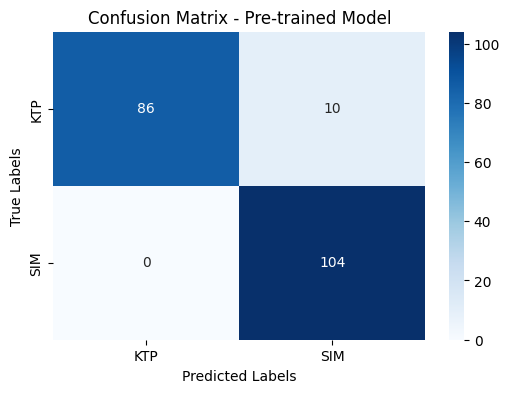


Evaluating fine-tuned model:


Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]<ipython-input-6-41eab0963e75>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'test_loss': 0.00017999727032684648, 'test_accuracy': 1.0, 'test_recall': 1.0, 'test_precision': 1.0, 'test_f1': 1.0, 'test_runtime': 47.04, 'test_samples_per_second': 4.251, 'test_steps_per_second': 0.276, 'true_labels': [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0], 'predictions': [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 

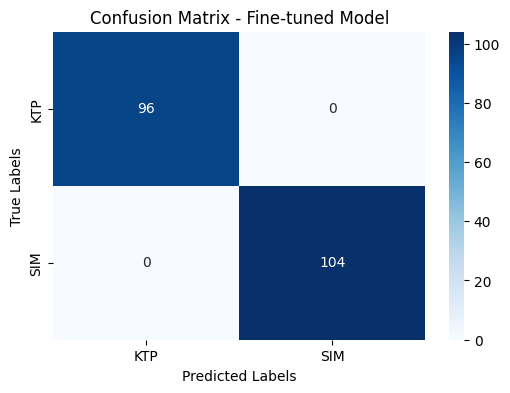

In [ ]:
# Pre-trained BERT model
pretrained_model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)

# Fine-tuned BERT model (assuming the model has been saved locally after training)
fine_tuned_model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)
# fine_tuned_model.load_state_dict(torch.load('/content/drive/MyDrive/Skripsi/Model/bert_model.pt'))
fine_tuned_model.load_state_dict(torch.load('/content/bert_model.pt'))

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Evaluation setup for pre-trained model
print("Evaluating pre-trained model:")
pretrained_metrics = evaluate_model(pretrained_model, test_loader)
print(pretrained_metrics)
plot_confusion_matrix(pretrained_metrics['true_labels'],
                      pretrained_metrics['predictions'],
                      title="Pre-trained Model")

# Evaluation setup for fine-tuned model
print("\nEvaluating fine-tuned model:")
fine_tuned_metrics = evaluate_model(fine_tuned_model, test_loader)
print(fine_tuned_metrics)
plot_confusion_matrix(fine_tuned_metrics['true_labels'],
                      fine_tuned_metrics['predictions'],
                      title="Fine-tuned Model")

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def predict(model, text):
    model.eval()

    inputs = tokenizer(
        text,
        return_tensors='pt',
        padding=True,
        truncation=True,
        max_length=128
    )

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    predictions = torch.argmax(logits, dim=1).item()
    probabilities = torch.softmax(logits, dim=1).squeeze().tolist()

    label_mapping = {0: "KTP", 1: "SIM"}
    predicted_label = label_mapping[predictions]

    return predicted_label, probabilities

In [ ]:
textKtp = "PROVINSI ACEH KOTA BANDA ACEH NIK: 6493290163658131 Nama: TANIA ZULAIKA Tempat/Tgl Lahir: BANDA ACEH 12-03-2030 Jenis Kelamin: PEREMPUAN Gol. Darah: A Alamat: JL. TERMINAL LAMA NO. 35 RT/RW: 003/008 Kel/Desa: PEUNITI Kecamatan: BAITURRAHMAN Agama: ISLAM Status Perkawinan: KAWIN KOTA BANDA ACEH Pekerjaan: KARYAWAN 31-08-2017 Kewarganegaraan: WNI Berlaku Hingga: SEUMUR HIDUP"
textSim = "INDONESIA DRIVING LICENSE SURAT IZIN MENGEMUDI C 1196-1535-37272 1. NABILA LESTARI 2. MALANG, 12-03-2030 3. A - WANITA 4. JL. JOMBANG 3A NO. 20 GADINGASRI, KLOJEN KOTA MALANG 5. KARYAWAN 6. JATIM 31-08-2045"

predicted_label, predicted_probabilities = predict(model, textKtp)
print(f"Actual label: KTP\nPredicted label: {predicted_label}\nProbabilities: {predicted_probabilities}\n")

predicted_label, predicted_probabilities = predict(model, textSim)
print(f"Actual label: SIM\nPredicted label: {predicted_label}\nProbabilities: {predicted_probabilities}")

Actual label: KTP
Predicted label: KTP
Probabilities: [0.9998170733451843, 0.00018289790023118258]

Actual label: SIM
Predicted label: SIM
Probabilities: [0.00017693534027785063, 0.9998230338096619]


In [ ]:
import re

def extract_ktp_data(text):
    data = {}
    # data['nik'] = re.search(r"NIK:\s*([\d]+)", text).group(1)
    nik_matches = re.findall(r"NIK:\s*([\d]+)", text)
    data['nik'] = nik_matches[0] if nik_matches else None

    # data['nama'] = re.search(r"Nama:\s*([A-Z\s]+)", text).group(1)
    nama_matches = re.findall(r"Nama:\s*([A-Z\s]+?)(?=\s*Tempat)", text)
    data['nama'] = nama_matches[0] if nama_matches else None

    # data['tempat_tanggal_lahir'] = re.search(r"Tempat/Tgl Lahir:\s*([A-Za-z,\s\d\-]+)", text).group(1)
    tempat_tanggal_lahir_matches = re.findall(r"Tempat/Tgl Lahir:\s*([A-Za-z\s\d\-]+?)(?=\s+Jenis)", text)
    data['tempat_tanggal_lahir'] = tempat_tanggal_lahir_matches[0]

    # data['jenis_kelamin'] = re.search(r"Jenis Kelamin:\s*(Laki-Laki|Perempuan)", text).group(1)
    jenis_kelamin_matches = re.findall(r"Jenis Kelamin:\s*(LAKI-LAKI|PEREMPUAN)", text)
    data['jenis_kelamin'] = jenis_kelamin_matches[0] if jenis_kelamin_matches else None

    # data['gol_darah'] = re.search(r"Gol. Darah:\s*(A|B|AB|O)", text).group(1)
    gol_darah_matches = re.findall(r"Gol. Darah:\s*(A|B|AB|O)", text)
    data['gol_darah'] = gol_darah_matches[0] if gol_darah_matches else None

    # data['alamat'] = re.search(r"Alamat:\s*([A-Za-z\s\.,\d\-]+)", text).group(1)
    alamat_matches = re.findall(r"Alamat:\s*([A-Za-z\s\.,\d\-]+?)(?=\s+RT)", text)
    data['alamat'] = alamat_matches[0] if alamat_matches else None

    # data['rt_rw'] = re.search(r"RT/RW:\s*([\d]+/\d+)", text).group(1)
    rt_rw_matches = re.findall(r"RT/RW:\s*([\d]+/\d+)", text)
    data['rt_rw'] = rt_rw_matches[0] if rt_rw_matches else None

    # data['kel_desa'] = re.search(r"Kel/Desa:\s*([A-Za-z\s]+)", text).group(1)
    kel_desa_matches = re.findall(r"Kel/Desa:\s*([A-Za-z\s]+?)(?=\s+Kecamatan)", text)
    data['kel_desa'] = kel_desa_matches[0] if kel_desa_matches else None

    # data['kecamatan'] = re.search(r"Kecamatan:\s*([A-Za-z\s]+)", text).group(1)
    kecamatan_matches = re.findall(r"Kecamatan:\s*([A-Za-z\s]+?)(?=\s+Agama)", text)
    data['kecamatan'] = kecamatan_matches[0] if kecamatan_matches else None

    # data['agama'] = re.search(r"Agama:\s*([A-Za-z\s]+)", text).group(1)
    agama_matches = re.findall(r"Agama:\s*([A-Za-z\s]+?)(?=\s+Status)", text)
    data['agama'] = agama_matches[0] if agama_matches else None

    # data['status_perkawinan'] = re.search(r"Status Perkawinan:\s*([A-Za-z\s]+)", text).group(1)
    status_perkawinan_matches = re.findall(r"Status Perkawinan:\s*s*(KAWIN|BELUM KAWIN)", text)
    data['status_perkawinan'] = status_perkawinan_matches[0] if status_perkawinan_matches else None

    # data['pekerjaan'] = re.search(r"Pekerjaan:\s*([A-Za-z\s\/]+)", text).group(1)
    pekerjaan_matches = re.findall(r"Pekerjaan:\s*([A-Za-z\s\/]+)", text)
    data['pekerjaan'] = pekerjaan_matches[0] if pekerjaan_matches else None

    # data['kewarganegaraan'] = re.search(r"Kewarganegaraan:\s*(WNI|WNA)", text).group(1)
    kewarganegaraan_matches = re.findall(r"Kewarganegaraan:\s*(WNI|WNA)", text)
    data['kewarganegaraan'] = kewarganegaraan_matches[0] if kewarganegaraan_matches else None

    # data['berlaku_hingga'] = re.search(r"Berlaku Hingga:\s*([\d\-]+)", text).group(1)
    berlaku_hingga_matches = re.findall(r"Berlaku Hingga:\s*(SEUMUR HIDUP)", text)
    data['berlaku_hingga'] = berlaku_hingga_matches[0] if berlaku_hingga_matches else None


    return data

def extract_sim_data(text):
    data = {}
    # data['license_type'] = re.search(r"License Type:\s*([A-C]+)", text).group(1)
    license_type_matches = re.findall(r"SURAT IZIN MENGEMUDI\s*([A-C]+)", text)
    data['license_type'] = license_type_matches[0] if license_type_matches else None

    # data['driving_number'] = re.search(r"Driving Number:\s*([\d\-]+)", text).group(1)
    driving_number_matches = re.findall(r"\s*([\d\-]+)", text)
    data['driving_number'] = driving_number_matches[0] if driving_number_matches else None

    # data['nama'] = re.search(r"Nama:\s*([A-Z\s]+)", text).group(1)
    nama_matches = re.findall(r"1.\s*([A-Z\s]+)\s", text)
    data['nama'] = nama_matches[0] if nama_matches else None

    # data['tempat_tanggal_lahir'] = re.search(r"Tempat/Tgl Lahir:\s*([A-Za-z,\s\d\-]+)", text).group(1)
    tempat_tanggal_lahir_matches = re.findall(r"2\.\s*([A-Za-z,\s\d\-]+?)(?=\s*\d+\.)", text)
    data['tempat_tanggal_lahir'] = tempat_tanggal_lahir_matches[0] if tempat_tanggal_lahir_matches else None

    # data['gol_darah'] = re.search(r"Gol. Darah:\s*(A|B|AB|O)", text).group(1)
    gol_darah_matches = re.findall(r"3.\s*(A|B|AB|O)", text)
    data['gol_darah'] = gol_darah_matches[0] if gol_darah_matches else None

    # data['jenis_kelamin'] = re.search(r"Jenis Kelamin:\s*(Laki-Laki|Perempuan)", text).group(1)
    jenis_kelamin_matches = re.findall(r"-\s*(PRIA|WANITA)", text)
    data['jenis_kelamin'] = jenis_kelamin_matches[0] if jenis_kelamin_matches else None

    # data['alamat'] = re.search(r"Alamat:\s*([A-Za-z\s\.,\d\-]+)", text).group(1)
    alamat_matches = re.findall(r"4\.\s*([A-Za-z0-9\s\.,\-]+?)(?=\s*5\.)", text)
    data['alamat'] = alamat_matches[0] if alamat_matches else None

    # data['pekerjaan'] = re.search(r"Pekerjaan:\s*([A-Za-z\s\/]+)", text).group(1)
    pekerjaan_matches = re.findall(r"5.\s*([A-Za-z\s\/]+)\s", text)
    data['pekerjaan'] = pekerjaan_matches[0] if pekerjaan_matches else None

    # data['domisili'] = re.search(r"Domisili:\s*([A-Z\s]+)", text).group(1)
    domisili_matches = re.findall(r"6\.\s*([A-Z]+)\s*", text)
    data['domisili'] = domisili_matches[0] if domisili_matches else None

    # data['berlaku_hingga'] = re.search(r"Berlaku Hingga:\s*([\d\-]+)", text).group(1)
    berlaku_hingga_matches = re.findall(r"6\.\s*[A-Z\s]+\s*(\d{2}-\d{2}-\d{4})", text)
    data['berlaku_hingga'] = berlaku_hingga_matches[0] if berlaku_hingga_matches else None


    return data

def classify_document(text):
    # Assuming model classification output is already available
    encoding = tokenizer(text, return_tensors='pt', max_length=128, truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**encoding)
    predicted_class = torch.argmax(outputs.logits).item()

    if predicted_class == 0:  # KTP
        ktp_data = extract_ktp_data(text)
        result = {
            "document_type": "KTP",
            "data": ktp_data
        }
    else:  # SIM
        sim_data = extract_sim_data(text)
        result = {
            "document_type": "SIM",
            "data": sim_data
        }

    return json.dumps(result, indent=4)

# Example usage
textKtp = "PROVINSI ACEH KOTA BANDA ACEH NIK: 6493290163658131 Nama: TANIA ZULAIKA Tempat/Tgl Lahir: BANDA ACEH 12-03-2030 Jenis Kelamin: PEREMPUAN Gol. Darah: A Alamat: JL. TERMINAL LAMA NO. 35 RT/RW: 003/008 Kel/Desa: PEUNITI Kecamatan: BAITURRAHMAN Agama: ISLAM Status Perkawinan: KAWIN KOTA BANDA ACEH Pekerjaan: KARYAWAN 31-08-2017 Kewarganegaraan: WNI Berlaku Hingga: SEUMUR HIDUP"
textSim = "INDONESIA DRIVING LICENSE SURAT IZIN MENGEMUDI C 1196-1535-37272 1. NABILA LESTARI 2. MALANG, 12-03-2030 3. A - WANITA 4. JL. JOMBANG 3A NO. 20 GADINGASRI, KLOJEN KOTA MALANG 5. KARYAWAN 6. JATIM 31-08-2045"
json_output = classify_document(textSim)
print(json_output)


{
    "document_type": "SIM",
    "data": {
        "license_type": "C",
        "driving_number": "1196-1535-37272",
        "nama": "NABILA LESTARI",
        "tempat_tanggal_lahir": "MALANG, 12-03-2030",
        "gol_darah": "A",
        "jenis_kelamin": "WANITA",
        "alamat": "JL. JOMBANG 3A NO. 20 GADINGASRI, KLOJEN KOTA MALANG",
        "pekerjaan": "KARYAWAN",
        "domisili": "JATIM",
        "berlaku_hingga": "31-08-2045"
    }
}
